# Logistic Regression Pipeline for H1ESC (GREG)

This notebook assesses variaegated implementations of the logistic regression models for the data dervied from the A549 cell-line in GREG.

## Contents

* [1. Loading Packages](#link1)
* [2. Loading Data](#link2)
* [3. Building Model](#link3)
* [4. Dealing with the *Paradox* of Accuracy ](#link4)
    * [4.1 Problem of Class Imbalance](#link5)
        * [4.1.1 Oversampling of minority class](#link6)
        * [4.1.2 Undersampling of minority class](#link7)
        * [4.1.3 SMOTE](#link8)
        * [4.1.4 Both over- and under-sampling](#link9)
* [5. Ratifying the *Pareto's Principle*](#link10)
    * [5.1 SMOTE data](#link11)
* [6. Visualizing Predictions](#link12)
* [7. Session Information](#link13)

### <a id=link1>1. Loading Packages </a>

In [1]:
install.packages("glmnet", repos = "https://cran.us.r-project.org")
library(glmnet)

Loading required package: Matrix

Loaded glmnet 4.0-2



### <a id=link2>2. Loading Data </a>

In [2]:
h1escgreg <- read.table("H1ESCforML.txt", header = TRUE) ## loading data
h1escgreg<- h1escgreg[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(h1escgreg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.00000,0.0000000,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.00000000,0.0000000,Non-Hub
2,0.00000,0.0000000,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.00000000,0.0000000,Non-Hub
3,0.00000,0.0000000,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.00000000,0.0000000,Non-Hub
4,0.00000,0.0000000,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.00000000,0.0000000,Non-Hub
5,0.00000,0.2230824,0.000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0,0.02765707,0.0000000,Non-Hub
6,35.88248,0.3718039,1.424037,1.3575,0.7813343,0.7305773,0,1.444572,0.1266057,0.279418,0,0.19359947,0.1803093,Non-Hub


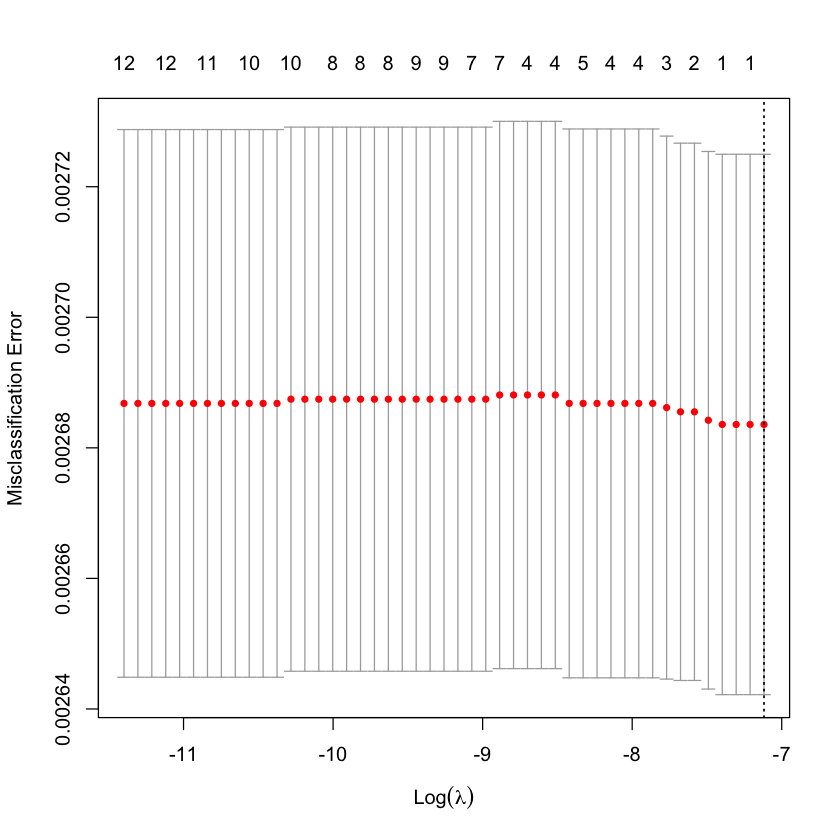

In [5]:
set.seed(005)
cv.modelfit <- cv.glmnet(as.matrix(h1escgreg[,1:13]),
                         h1escgreg$Class,
                         family = "binomial",
                         type.measure = "class",
                         alpha = 1,
                         nlambda = 100)


plot(cv.modelfit)

In [6]:
cat("There are", length(cv.modelfit$lambda),
    "lambda values in all:\n",
    cv.modelfit$lambda,
    "\n, out of which",
    min(cv.modelfit$lambda),
    "is the minimum, while",
    cv.modelfit$lambda.1se,
    "denotes the value at which the model is optimized at one standard error.")

There are 47 lambda values in all:
 0.0008099085 0.0007379584 0.0006724002 0.0006126661 0.0005582385 0.0005086461 0.0004634594 0.000422287 0.0003847721 0.00035059 0.0003194446 0.000291066 0.0002652085 0.0002416481 0.0002201808 0.0002006205 0.0001827979 0.0001665587 0.0001517621 0.0001382799 0.0001259955 0.0001148024 0.0001046037 9.5311e-05 8.684383e-05 7.912886e-05 7.209927e-05 6.569417e-05 5.985808e-05 5.454046e-05 4.969523e-05 4.528045e-05 4.125786e-05 3.759262e-05 3.4253e-05 3.121005e-05 2.843744e-05 2.591114e-05 2.360926e-05 2.151188e-05 1.960082e-05 1.785954e-05 1.627295e-05 1.48273e-05 1.351009e-05 1.230989e-05 1.121631e-05 
, out of which 1.121631e-05 is the minimum, while 0.0008099085 denotes the value at which the model is optimized at one standard error.

### <a id=link3>3. Building Model </a>

In [7]:
set.seed(2)
modelfit <- glmnet(as.matrix(h1escgreg[,1:13]),
                   h1escgreg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = min(cv.modelfit$lambda))
# Listing non-zero coefficients
print(modelfit$beta[,1])

Warning message:
“from glmnet Fortran code (error code -1); Convergence for 1th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message in getcoef(fit, nvars, nx, vnames):
“an empty model has been returned; probably a convergence issue”


    CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
       0        0        0        0        0        0        0        0 
 H3K9me3    RAD21  RNA.Seq  RNAPol2      YY1 
       0        0        0        0        0 


For a standard usage, supplying a single <i>lambda</i> value is not advisable (See <a href= "https://cran.r-project.org/web/packages/glmnet/glmnet.pdf" > here </a>). There could be a convergence issue, as above, and so the better ways is to have the function decide for itself amongst an array of values. Let us attempt again, with the new theme.

In [8]:
set.seed(3)
modelfit <- glmnet(as.matrix(h1escgreg[,1:13]),
                   h1escgreg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = cv.modelfit$lambda)
# Listing non-zero coefficients
print(modelfit$beta[,1])

         CTCF         EP300      H3K27me3      H3K36me3       H3K4me1 
 0.000000e+00 -2.693701e-16  0.000000e+00  0.000000e+00  0.000000e+00 
      H3K4me2       H3K4me3        H3K9ac       H3K9me3         RAD21 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
      RNA.Seq       RNAPol2           YY1 
 0.000000e+00  0.000000e+00  0.000000e+00 


In [9]:
coef(modelfit)[,1]
predict(modelfit, type="coef")

(Intercept)          CTCF         EP300      H3K27me3      H3K36me3 
 5.917916e+00  0.000000e+00 -2.693701e-16  0.000000e+00  0.000000e+00 
      H3K4me1       H3K4me2       H3K4me3        H3K9ac       H3K9me3 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
        RAD21       RNA.Seq       RNAPol2           YY1 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00

   [[ suppressing 47 column names ‘s0’, ‘s1’, ‘s2’ ... ]]



14 x 47 sparse Matrix of class "dgCMatrix"
                                                                        
(Intercept)  5.917916e+00  5.93250310  5.9369254  5.93953473  5.94145779
CTCF         .             .           .          .           .         
EP300       -2.693701e-16 -0.02236828 -0.0289948 -0.03284231 -0.03564675
H3K27me3     .             .           .          .           .         
H3K36me3     .             .           .          .           .         
H3K4me1      .             .           .          .           .         
H3K4me2      .             .           .          .           .         
H3K4me3      .             .           .          .           .         
H3K9ac       .             .           .          .           .         
H3K9me3      .             .           .          .           .         
RAD21        .             .           .          .           .         
RNA.Seq      .             .           .          .           .         
RNAPol2 

In [11]:
set.seed(4) # for reproducibility of results.
h1escgreg$Class <- as.numeric(as.factor(h1escgreg$Class))-1
part <- sample(2, nrow(h1escgreg),
               replace = TRUE,
               prob = c(0.7,0.3))
train <- h1escgreg[part==1,]
test <- h1escgreg[part==2,]
cat("So, now we have",
    nrow(train),
    "training rows and",
    nrow(test),
    "testing rows")

h1escmodel <- glm(formula = Class ~ .,
               data = train,
               family = "binomial")
summary(h1escmodel)

So, now we have 1084535 training rows and 464887 testing rows

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8551   0.0681   0.0716   0.0748   2.2258  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.1071120  0.0280476 217.741  < 2e-16 ***
CTCF         0.0744010  0.0224502   3.314  0.00092 ***
EP300       -0.0796677  0.0195032  -4.085 4.41e-05 ***
H3K27me3    -0.0205721  0.0045987  -4.473 7.70e-06 ***
H3K36me3    -0.0716736  0.0182670  -3.924 8.72e-05 ***
H3K4me1     -0.1405031  0.0262222  -5.358 8.41e-08 ***
H3K4me2      0.0548733  0.0182348   3.009  0.00262 ** 
H3K4me3     -0.1434262  0.0196805  -7.288 3.15e-13 ***
H3K9ac       0.2069055  0.0319185   6.482 9.03e-11 ***
H3K9me3     -0.0080277  0.0318560  -0.252  0.80104    
RAD21       -0.1175671  0.0229053  -5.133 2.86e-07 ***
RNA.Seq     -0.0008596  0.0006769  -1.270  0.20410    
RNAPol2     -0.0152003  0.0097391  -1.561  0.11858    
YY1          0.0075076  0.0189122 

<h5> Variance Inflation Factors(VIF) </h5>


<p align= "justify"> The state of <a href = "https://www.investopedia.com/terms/m/multicollinearity.asp" > multicollinearity </a> is a common check enroute building of an effective regression model. When two or more predictor(independent) variables are correlated with each other, they do not offer much to the model structure and kind of induce <i>redundancy</i>.</p>
<p align="justify"> A general guideline is that a VIF larger than 5, then that predictor is more related to the other predictors than it is to the response. Contrarily, a VIF value of 1 for a predictor variable indicates that there is no correlation with other predictors, and a VIF value between 1 and 5 is representative of a moderate correlation. <b>The user can choose to remove the independent variables with a high VIF and a high p-value</b>.</p>

In [12]:
install.packages("rms",repos = "https://cran.us.r-project.org")
library(rms)

vif(h1escmodel)


The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//Rtmp9zQeiv/downloaded_packages


Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
10.485787  3.858458  1.821899 15.356743  7.723808  9.511523  9.682681 21.780140 
  H3K9me3     RAD21   RNA.Seq   RNAPol2       YY1 
 2.103323  4.878538  1.030444  2.133204  5.219354

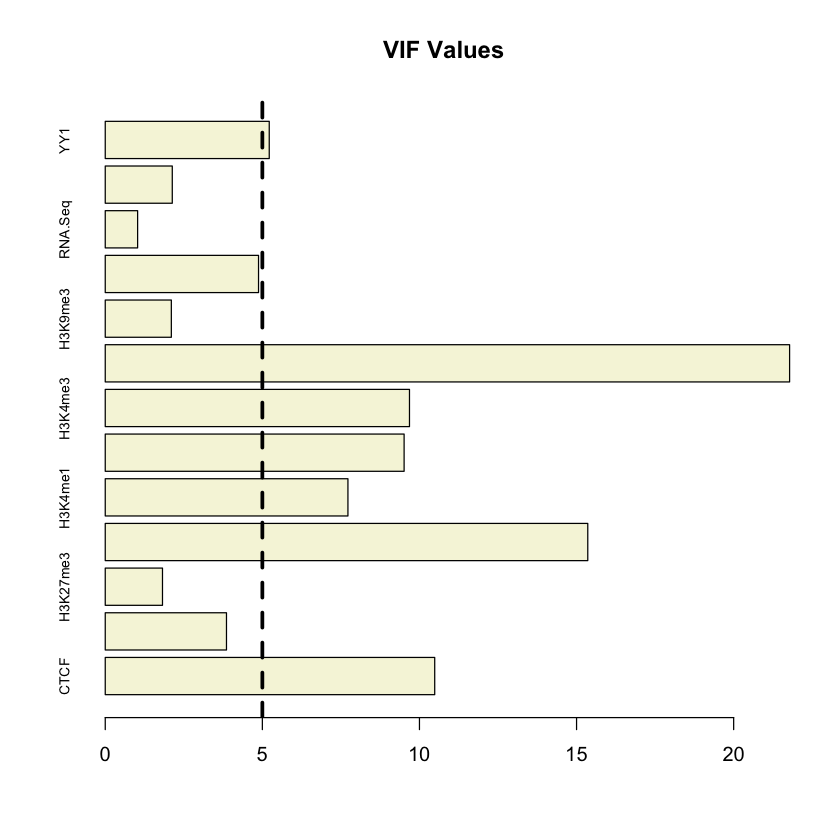

In [18]:
#create horizontal bar chart to display each VIF value
barplot(vif(h1escmodel), main = "VIF Values", horiz = TRUE, col = "beige", cex.names=.7)

#add vertical line at 5
abline(v = 5, lwd = 3, lty = 2)

Initial observation is that amongst others, the variable <b>YY1</b> has a high p-value and a marginally high VIF (5.22). In contrast, <b>H3K4me2</b> has a low p-value (0.01) and a high VIF (9.51). In such a case, the former can be omitted from the model. Let us re-design the model without YY1.  

In [22]:
h1escmodel1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = train,
               family = "binomial")
summary(h1escmodel1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8591   0.0681   0.0716   0.0748   2.3197  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.105361   0.027901 218.819  < 2e-16 ***
CTCF         0.074510   0.022482   3.314 0.000919 ***
EP300       -0.075579   0.015686  -4.818 1.45e-06 ***
H3K27me3    -0.020446   0.004596  -4.448 8.65e-06 ***
H3K36me3    -0.075434   0.017513  -4.307 1.65e-05 ***
H3K4me1     -0.139531   0.026240  -5.317 1.05e-07 ***
H3K4me2      0.055240   0.018225   3.031 0.002438 ** 
H3K4me3     -0.144126   0.019685  -7.322 2.45e-13 ***
H3K9ac       0.211779   0.031238   6.780 1.21e-11 ***
H3K9me3     -0.006299   0.031897  -0.197 0.843452    
RAD21       -0.115867   0.022419  -5.168 2.36e-07 ***
RNAPol2     -0.015370   0.009444  -1.627 0.103

In [23]:
# Examine the VIF for the variables in the new model.
vif(h1escmodel1)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
10.366810  2.397840  1.808430 13.883554  7.629533  9.468991  9.681347 20.525082 
  H3K9me3     RAD21   RNAPol2 
 2.082880  4.608605  1.992745

This seems a good improvisation than before as just two variables (<i>H3K9me3</i> and <i>RNAPol2</i>) demonstrate a high p-value, but an acceptable VIF. We'll stick to this model.

In [24]:
yTrain <- predict(h1escmodel1, train, type = "response")
head(yTrain)

1         2         3         4         6        10 
0.9977741 0.9977741 0.9977741 0.9977741 0.9998523 0.9976492

In [25]:
head(train)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0.00000,0.0000000,0.0000000,1
2,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0.00000,0.0000000,0.0000000,1
3,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0.00000,0.0000000,0.0000000,1
4,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000000,0,0.000000,0.0000000,0.000000,0.00000,0.0000000,0.0000000,1
6,35.8824840,0.3718039,1.4240371,1.3575,0.7813343,0.7305773,0,1.444572,0.1266057,0.279418,0.00000,0.1935995,0.1803093,1
10,0.8751825,0.0000000,0.8215599,2.7150,1.1329347,0.4522622,0,1.108625,0.0000000,0.000000,11.44359,0.0000000,0.0000000,1


In [26]:
prediction_probabilities_train <- ifelse(yTrain > 0.5, 1, 0) # Probabilities to Labels conversion
confusion_matrix_train <- table(Predicted = prediction_probabilities_train, Actual = train$Class)
print(confusion_matrix_train)

         Actual
Predicted       0       1
        0       0       3
        1    2926 1081606


In [27]:
misclassfication_error_train <- 1- sum(diag(confusion_matrix_train))/sum(confusion_matrix_train)
cat("The misclassification error in train data is",
    (round(misclassfication_error_train*100)), "percent")

The misclassification error in train data is 0 percent

In [29]:
yTest <- predict(h1escmodel1, test, type = "response")
prediction_probabilities_test <- ifelse(yTest > 0.5, 1, 0)
confusion_matrix_test <- table(Predicted = prediction_probabilities_test, Actual = test$Class)
print(confusion_matrix_test)

         Actual
Predicted      0      1
        0      0      2
        1   1232 463653


In [30]:
misclassfication_error_test <- 1- sum(diag(confusion_matrix_test))/sum(confusion_matrix_test)
cat("The misclassification error in test data is",
    (round(misclassfication_error_test*100)), "percent")

The misclassification error in test data is 0 percent

In [31]:
overall_p <- with(h1escmodel1,
                  pchisq(null.deviance-deviance,
                         df.null-df.residual,
                         lower.tail = FALSE))
cat("The statistical significance for the model is", overall_p, "\n")

The statistical significance for the model is 9.416662e-47 


In [32]:
cat("The confidence level for this model is",
    ((1-overall_p)*100), "percent")

The confidence level for this model is 100 percent

We can clearly observe that the model has **zero sensitivity** and **high specificity**. It means that the model is **highly biased towards the Non-Hubs** and that solely accounts for the data imbalance.

### <a id=link4>4. Dealing with the *Paradox* of Accuracy  </a>

The model is highly accurate in predicting the non-hubs individually. Since the data carries significant imbalance in the classes (non-hubs are far more in number than the hubs), the prediction for the hubs might not be well suited. We need to extend the analysis for a "balanced" data. But before we delve further, let us calculate the sensitivity and specificity parameters to check how well the model is able to identify positive class labels (0: hubs).

In [33]:
library(caret)
library(e1071)


Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster



Attaching package: ‘e1071’


The following object is masked from ‘package:Hmisc’:

    impute




In [34]:
sensitivity(confusion_matrix_train)

[1] 0

In [35]:
specificity(confusion_matrix_train)

[1] 0.9999972

In [36]:
sensitivity(confusion_matrix_test)

[1] 0

In [37]:
specificity(confusion_matrix_test)

[1] 0.9999957

This is clearly not what we want.

####  <a id=link5>4.1 Problem of Class Imbalance </a>

The problem of class imbalance presents a warranting scenario for data normalization in terms of class proportions. Two simple strategies to mitigate this problem are oversampling and undersampling.

#####  <a id=link5> 4.1.1 Oversampling of minority class </a>

In [38]:
table(h1escgreg$Class)


      0       1 
   4158 1545264 

We can articulate that the hubs(class marked with '0') are way less than the non-hubs. To scale them in proportion to the non-hubs, we can choose to oversample their instances. This is carried out by randomly choosing their exisiting data points and repeating to match a specified number. The package ***ROSE*** comes in handy here. The details about the package could be found [here](https://www.rdocumentation.org/packages/ROSE/versions/0.0-3).

In [43]:
install.packages("ROSE", dependencies = TRUE, repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/")
library(ROSE)

also installing the dependency ‘tree’





The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//Rtmp9zQeiv/downloaded_packages


Loaded ROSE 0.0-3




In [46]:
overTrain <- ovun.sample(Class ~., data = train, method = "over", N = 1549422)$data

In [47]:
table(overTrain$Class)


      0       1 
 467813 1081609 

Still better. Let's run the model again to see if there is any improvement in the performance.

In [48]:
h1escmodel1Over <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = overTrain,
               family = "binomial")
summary(h1escmodel1Over)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = overTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8811  -1.4001   0.7604   0.8527   8.4904  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  1.3654001  0.0036533  373.747  < 2e-16 ***
CTCF         0.0712175  0.0021527   33.083  < 2e-16 ***
EP300       -0.5182176  0.0044976 -115.220  < 2e-16 ***
H3K27me3    -0.0260836  0.0006745  -38.669  < 2e-16 ***
H3K36me3    -0.1549167  0.0021757  -71.205  < 2e-16 ***
H3K4me1     -0.0491044  0.0028842  -17.026  < 2e-16 ***
H3K4me2      0.0648200  0.0021439   30.235  < 2e-16 ***
H3K4me3     -0.0980011  0.0026501  -36.979  < 2e-16 ***
H3K9ac       0.0572795  0.0032755   17.487  < 2e-16 ***
H3K9me3      0.0189412  0.0033865    5.593 2.23e-08 ***
RAD21       -0.1062130  0.0024849  -42.744  < 2e-16 ***
RNAPol2      0.025

In [49]:
yTestOver <- predict(h1escmodel1Over, test, type = "response")
prediction_probabilities_testOver <- ifelse(yTestOver > 0.5, 1, 0)
confusion_matrix_testOver <- table(Predicted = prediction_probabilities_testOver, Actual = test$Class)
print(confusion_matrix_testOver)

         Actual
Predicted      0      1
        0     56   8558
        1   1176 455097


In [50]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testOver))*100, "%")

The sensitivity of the model is 4.545455 %

In [51]:
cat("The specificity of the model is", (specificity(confusion_matrix_testOver))*100, "%")

The specificity of the model is 98.15423 %

This is better than before but still not good enough. Maybe we can try the other approach.

##### <a id=link5> 4.1.2 Undersampling of majority class  </a>

Contrary to what we did above, we shall now scale down the random data points from the majority class and see if the model performs any better.

In [67]:
underTrain <- ovun.sample(Class ~., data = train, method = "under", N= 6000)$data
table(underTrain$Class)


   0    1 
2926 3074 

In [68]:
h1escmodel1Under <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = underTrain,
               family = "binomial")
summary(h1escmodel1Under)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = underTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6191  -1.2010   0.9418   1.1214   2.2870  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.56510    0.05417  10.431  < 2e-16 ***
CTCF         0.05540    0.03642   1.521   0.1282    
EP300       -0.47542    0.07094  -6.702 2.05e-11 ***
H3K27me3    -0.02837    0.01178  -2.407   0.0161 *  
H3K36me3    -0.18639    0.03438  -5.421 5.94e-08 ***
H3K4me1     -0.07520    0.04485  -1.677   0.0936 .  
H3K4me2      0.04977    0.03437   1.448   0.1476    
H3K4me3     -0.08211    0.04069  -2.018   0.0436 *  
H3K9ac       0.02361    0.04725   0.500   0.6173    
H3K9me3      0.06981    0.05004   1.395   0.1630    
RAD21       -0.09185    0.04204  -2.185   0.0289 *  
RNAPol2      0.04971    0.01990   2.498   0.0125 *  


In [69]:
yTestUnder <- predict(h1escmodel1Under, test, type = "response")
prediction_probabilities_testUnder <- ifelse(yTestUnder > 0.5, 1, 0)
confusion_matrix_testUnder <- table(Predicted = prediction_probabilities_testUnder, Actual = test$Class)
print(confusion_matrix_testUnder)

         Actual
Predicted      0      1
        0    495 137545
        1    737 326110


In [70]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testUnder))*100, "%")

The sensitivity of the model is 40.17857 %

In [71]:
cat("The specificity of the model is", (specificity(confusion_matrix_testUnder))*100, "%")

The specificity of the model is 70.33462 %

This case is somewhat balanced, not only in terms of respective data points but also sensivitiy and specificity of the classifier.

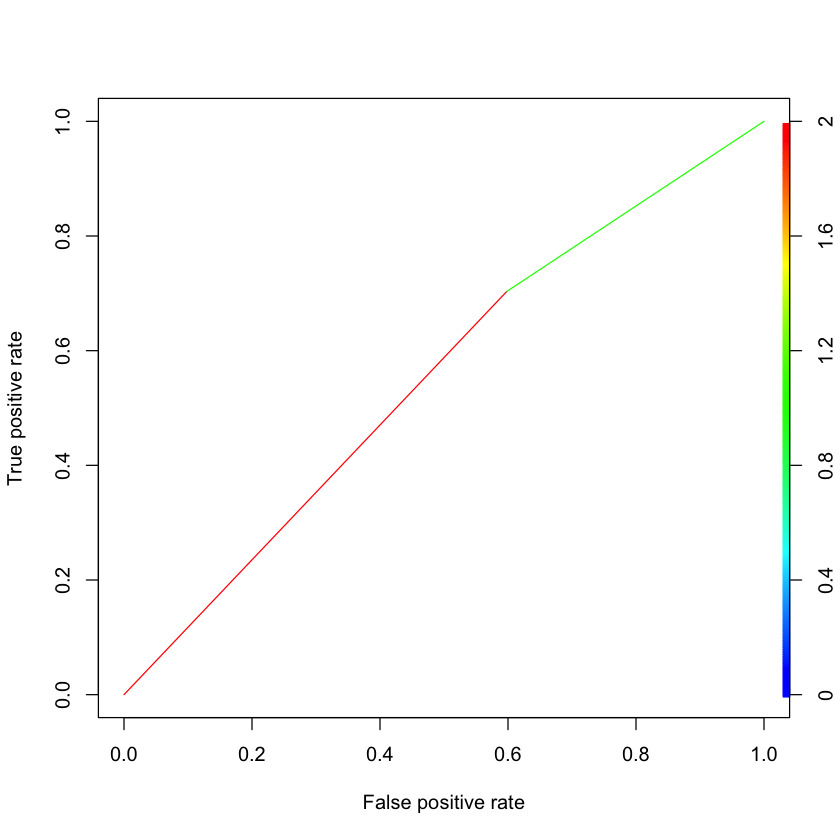

In [72]:
library(ROCR)

pred <- prediction(prediction_probabilities_testUnder, test$Class)
perf <- performance(pred, "tpr", "fpr")
plot(perf, colorize = TRUE)

##### <a id=link8> 4.1.3 SMOTE  </a>

The sampling techniques are straighforward, but could possibly engender a classifier that overfits the training data and hence might not be suitable for a general application. To handle such a chance, [SMOTE](https://www3.nd.edu/~dial/publications/chawla2002smote.pdf) was introduced by Chawla et al. in 2002 and the functionality is available in R with the package *DMwR*.

In [74]:
install.packages("DMwR", dependencies = TRUE, repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/")
library(DMwR)


The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//Rtmp9zQeiv/downloaded_packages


Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [75]:
## Smote : Synthetic Minority Oversampling Technique
## A pre-requisite is that the class variable in the data must be of "factor" category. Let's do that conversion.
train$Class <- as.factor(train$Class)

smoteData <- SMOTE(Class ~., train, perc.over = 100000, k = 5, perc.under = 100)

table(smoteData$Class)


      0       1 
2928926 2926000 

In [76]:
h1escmodel1SMOTE <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = smoteData,
               family = "binomial")
summary(h1escmodel1SMOTE)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = smoteData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5512  -1.1743  -0.3008   1.1384   8.4904  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  0.5902208  0.0017940  329.001  < 2e-16 ***
CTCF         0.0876527  0.0011353   77.208  < 2e-16 ***
EP300       -0.5789593  0.0022856 -253.304  < 2e-16 ***
H3K27me3    -0.0294683  0.0004091  -72.034  < 2e-16 ***
H3K36me3    -0.1748817  0.0011350 -154.083  < 2e-16 ***
H3K4me1     -0.0542749  0.0014816  -36.633  < 2e-16 ***
H3K4me2      0.0882929  0.0011773   74.999  < 2e-16 ***
H3K4me3     -0.1298709  0.0015439  -84.119  < 2e-16 ***
H3K9ac       0.0136000  0.0018959    7.174 7.31e-13 ***
H3K9me3      0.0248467  0.0016846   14.750  < 2e-16 ***
RAD21       -0.1167621  0.0013556  -86.135  < 2e-16 ***
RNAPol2      0.064

Let us now examine this model with the test data.

In [77]:
yTestSMOTE <- predict(h1escmodel1SMOTE, test, type = "response")
prediction_probabilities_testSMOTE <- ifelse(yTestSMOTE > 0.5, 1, 0)
confusion_matrix_testSMOTE <- table(Predicted = prediction_probabilities_testSMOTE, Actual = test$Class)
print(confusion_matrix_testSMOTE)

         Actual
Predicted      0      1
        0    610 177428
        1    622 286227


In [78]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testSMOTE))*100, "%")

The sensitivity of the model is 49.51299 %

In [79]:
cat("The specificity of the model is", (specificity(confusion_matrix_testSMOTE))*100, "%")

The specificity of the model is 61.73275 %

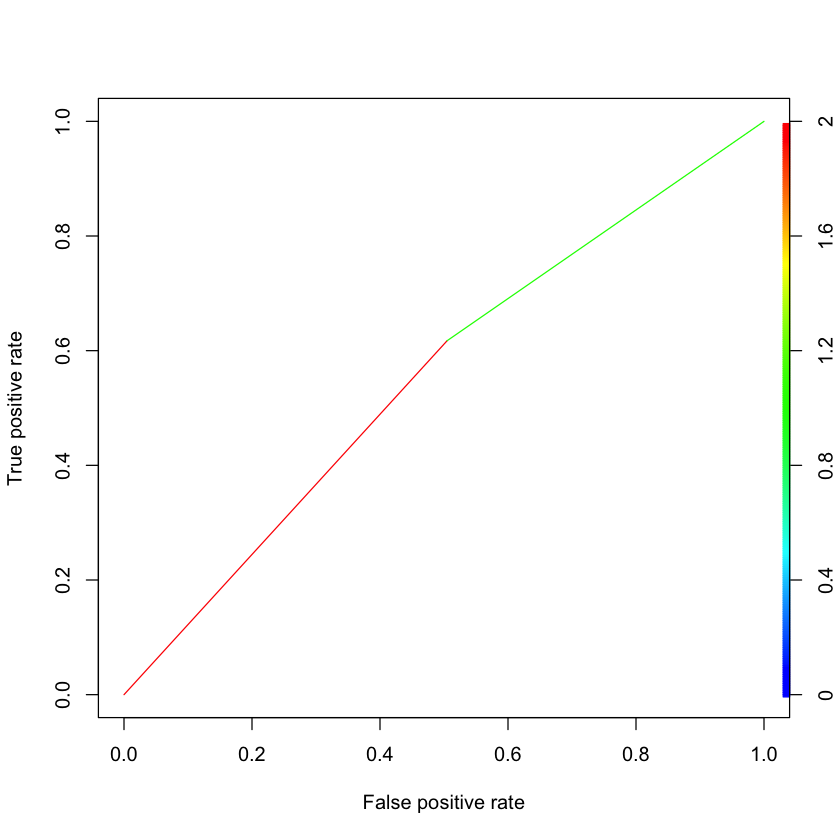

In [80]:
predSMOTE <- prediction(prediction_probabilities_testSMOTE, test$Class)
perfSMOTE <- performance(predSMOTE, "tpr", "fpr")
plot(perfSMOTE, colorize = TRUE)

##### <a id=link9> 4.1.4 Both over- and under-sampling </a>

This model has slightly better specificity than the previous model. In tandem, we could also try yet another flavor of the *ovun.sample()* function - to have under- and over-sampling both in parallel. This could be a likely run like the SMOTE as above.

In [81]:
bothTrain <- ovun.sample(Class ~., data = train, method = "both", N= 1081609)$data
table(bothTrain$Class)


     1      0 
540402 541207 

In [82]:
h1escmodel1Both <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2,
               data = bothTrain,
               family = "binomial")
summary(h1escmodel1Both)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = bothTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.1371   0.2818   1.1764   1.4901  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.5773403  0.0041364 -139.576  < 2e-16 ***
CTCF        -0.0688993  0.0024848  -27.728  < 2e-16 ***
EP300        0.5404656  0.0052392  103.159  < 2e-16 ***
H3K27me3     0.0315772  0.0009471   33.340  < 2e-16 ***
H3K36me3     0.1748368  0.0026169   66.811  < 2e-16 ***
H3K4me1      0.0525032  0.0033455   15.694  < 2e-16 ***
H3K4me2     -0.0667370  0.0025493  -26.178  < 2e-16 ***
H3K4me3      0.0953364  0.0032561   29.279  < 2e-16 ***
H3K9ac      -0.0108255  0.0042019   -2.576  0.00998 ** 
H3K9me3     -0.0208925  0.0038797   -5.385 7.24e-08 ***
RAD21        0.1015748  0.0029603   34.313  < 2e-16 ***
RNAPol2     -0.042

In [83]:
yTestBoth <- predict(h1escmodel1Both, test, type = "response")
prediction_probabilities_testBoth <- ifelse(yTestBoth > 0.5, 1, 0)
confusion_matrix_testBoth <- table(Predicted = prediction_probabilities_testBoth, Actual = test$Class)
print(confusion_matrix_testBoth)

         Actual
Predicted      0      1
        0    633 289556
        1    599 174099


In [84]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testBoth))*100, "%")

The sensitivity of the model is 51.37987 %

In [85]:
cat("The specificity of the model is", (specificity(confusion_matrix_testBoth))*100, "%")

The specificity of the model is 37.54926 %

These numbers aren't as good. Hitherto, the model with SMOTE data has performed the best.

### <a id=link10>5. Ratifying the *Pareto's Principle* </a>

The 80:20 rule is omnipresent in the domains of business and economy. Hardly would have the italian economist known at the time that his [theory](https://en.wikipedia.org/wiki/Pareto_principle) would be rooted deeper than his perception. 

In [86]:
set.seed(6) # for reproducibility of results.
parts <- sample(2, nrow(h1escgreg),
               replace = TRUE,
               prob = c(0.8,0.2))
training <- h1escgreg[parts==1,]
testing <- h1escgreg[parts==2,]
cat("So, now we have", nrow(training), "training rows and", nrow(testing), "testing rows")

So, now we have 1239682 training rows and 309740 testing rows

In [87]:
h1escparetoModel <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, 
                        data = training, 
                        family = "binomial")
summary(h1escparetoModel)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9134   0.0679   0.0713   0.0744   3.3222  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.128105   0.026936 227.503  < 2e-16 ***
CTCF         0.089985   0.021505   4.184 2.86e-05 ***
EP300       -0.048816   0.014586  -3.347 0.000818 ***
H3K27me3    -0.015242   0.004568  -3.337 0.000847 ***
H3K36me3    -0.077050   0.016106  -4.784 1.72e-06 ***
H3K4me1     -0.163138   0.022919  -7.118 1.09e-12 ***
H3K4me2      0.036044   0.016398   2.198 0.027947 *  
H3K4me3     -0.119361   0.017929  -6.657 2.79e-11 ***
H3K9ac       0.145488   0.027256   5.338 9.41e-08 ***
H3K9me3     -0.012040   0.028776  -0.418 0.675646    
RAD21       -0.123385   0.021203  -5.819 5.91e-09 ***
RNAPol2      0.012022   0.011305   1.063 0.

In [88]:
yTesting <- predict(h1escparetoModel, testing, type = "response")
prediction_probabilities_testing <- ifelse(yTesting > 0.5, 1, 0)
confusion_matrix_testing <- table(Predicted = prediction_probabilities_testing, Actual = testing$Class)
print(confusion_matrix_testing)

         Actual
Predicted      0      1
        0      0      3
        1    839 308898


We see here that the issue of class imbalance imposes skewness on the classifier to predict solely non-hubs (represented by "1"). The balancing of the data, as practiced above, might come to the rescue. Let's examine the performance of the classifier on SMOTE transformed data.

#### <a id=link11>5.1 SMOTE data </a>

In [125]:
training$Class <- as.factor(training$Class)
smoteDatum <- SMOTE(Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, 
                    training, 
                    perc.over = 10000, 
                    k = 7, 
                    perc.under = 99)
table(smoteDatum$Class)


     0      1 
335219 328581 

In [126]:
h1escparetoModelSmote <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, 
                             data = smoteDatum, 
                             family = "binomial")
summary(h1escparetoModelSmote)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9ac + H3K9me3 + RAD21 + RNAPol2, family = "binomial", 
    data = smoteDatum)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8528  -1.1674  -0.6055   1.1454   8.4904  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.562072   0.005342 105.211  < 2e-16 ***
CTCF         0.109503   0.003476  31.501  < 2e-16 ***
EP300       -0.558658   0.006877 -81.230  < 2e-16 ***
H3K27me3    -0.020447   0.001157 -17.672  < 2e-16 ***
H3K36me3    -0.154733   0.003469 -44.607  < 2e-16 ***
H3K4me1     -0.081429   0.004341 -18.760  < 2e-16 ***
H3K4me2      0.048267   0.003559  13.561  < 2e-16 ***
H3K4me3     -0.075954   0.004596 -16.526  < 2e-16 ***
H3K9ac      -0.039805   0.005697  -6.988 2.80e-12 ***
H3K9me3      0.022913   0.004978   4.603 4.16e-06 ***
RAD21       -0.128809   0.004137 -31.137  < 2e-16 ***
RNAPol2      0.084163   0.002353  35.768 

In [127]:
yTestingSmote <- predict(h1escparetoModelSmote, testing, type = "response")
prediction_probabilities_testingSmote <- ifelse(yTestingSmote > 0.5, 1, 0)
confusion_matrix_testingSmote <- table(Predicted = prediction_probabilities_testingSmote, Actual = testing$Class)
print(confusion_matrix_testingSmote)

         Actual
Predicted      0      1
        0    434 125610
        1    405 183291


In [128]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testingSmote))*100, "%")

The sensitivity of the model is 51.72825 %

In [129]:
cat("The specificity of the model is", (specificity(confusion_matrix_testingSmote))*100, "%")

The specificity of the model is 59.33649 %

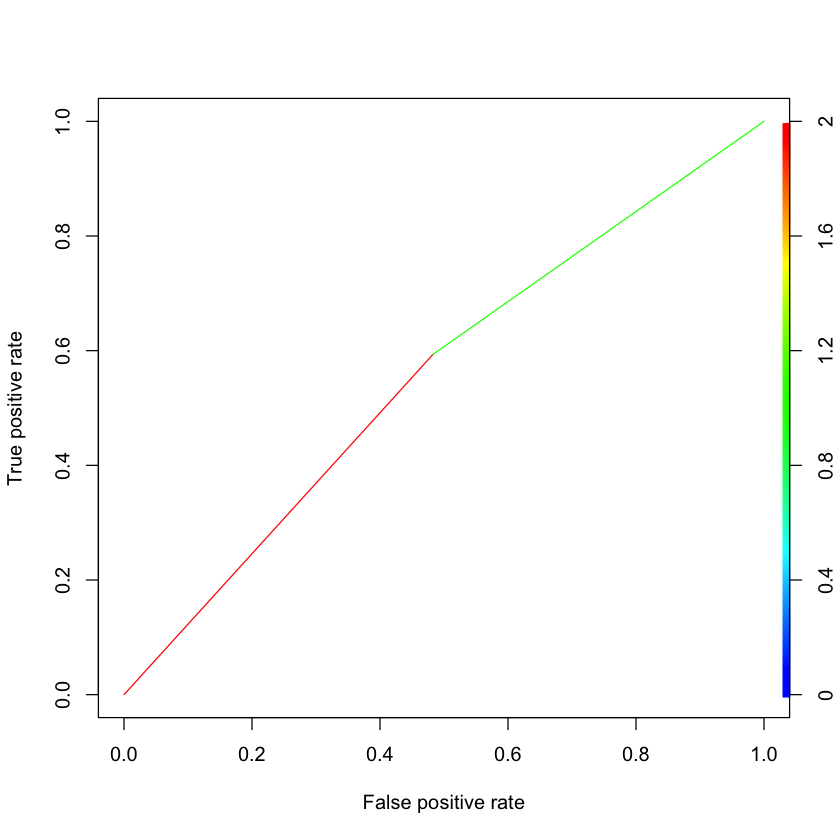

In [130]:
predictingSMOTE <- prediction(prediction_probabilities_testingSmote, testing$Class)
performanceSMOTE <- performance(predictingSMOTE, "tpr", "fpr")
plot(performanceSMOTE, colorize = TRUE)

### <a id=link12>6. Visualizing Predictions </a>

We choose to go with the current model and will save the prediction results, that shall be later utilized for plotting.

In [131]:
h1escgregModelPredictions <- predict(h1escparetoModelSmote, h1escgreg, type = "response")
h1escgregModelPredictionsProbs <- ifelse(h1escgregModelPredictions > 0.5, 1, 0)

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the H1ESC cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

The workflow commences with the installation of <a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz </a> - the package we aim to deploy for the visualization.

In [132]:
BiocManager::install("Gviz")
library(Gviz)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, 

Next, we recall the data from the H1ESC cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need!

In [133]:
h1escgregStandard <- read.table("H1ESCforML.txt", header = TRUE) ## full data
h1escgregStandardRegionsClass <- h1escgregStandard[, c(1:3,17)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [134]:
# Extracting chr21 data

h1escgregChr21NonHub <- h1escgregStandardRegionsClass[h1escgregStandardRegionsClass$chr=="chr21" & h1escgregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
h1escgregChr21Hub <- h1escgregStandardRegionsClass[h1escgregStandardRegionsClass$chr=="chr21" & h1escgregStandardRegionsClass$Class=="Hub", ]

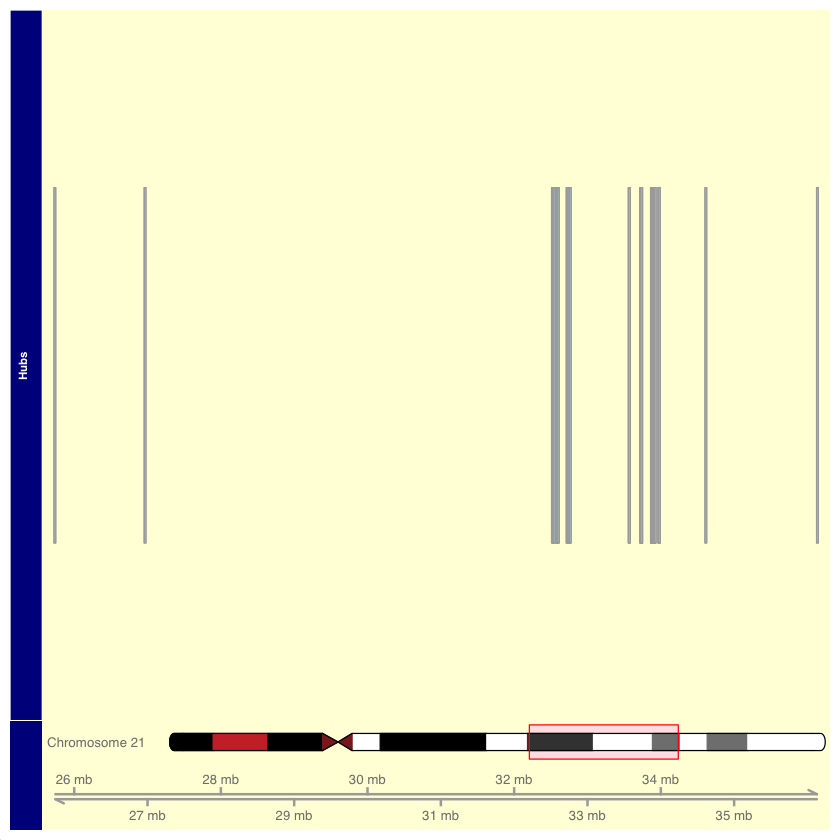

In [135]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = h1escgregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

So, there is a narrow occurrence of "hubs" in the chromosome 21, as seen above. The specific locations are given below.

In [136]:
print(h1escgregChr21Hub)

         chr    start      end Class
810340 chr21 25734001 25736000   Hub
810341 chr21 25736001 25738000   Hub
810955 chr21 26964001 26966000   Hub
810956 chr21 26966001 26968000   Hub
813733 chr21 32520001 32522000   Hub
813734 chr21 32522001 32524000   Hub
813742 chr21 32538001 32540000   Hub
813743 chr21 32538001 32540000   Hub
813744 chr21 32540001 32542000   Hub
813745 chr21 32540001 32542000   Hub
813746 chr21 32542001 32544000   Hub
813747 chr21 32542001 32544000   Hub
813748 chr21 32544001 32546000   Hub
813749 chr21 32544001 32546000   Hub
813769 chr21 32584001 32586000   Hub
813770 chr21 32584001 32586000   Hub
813771 chr21 32586001 32588000   Hub
813772 chr21 32586001 32588000   Hub
813773 chr21 32588001 32590000   Hub
813774 chr21 32588001 32590000   Hub
813775 chr21 32590001 32592000   Hub
813776 chr21 32590001 32592000   Hub
813777 chr21 32592001 32594000   Hub
813778 chr21 32592001 32594000   Hub
813779 chr21 32594001 32596000   Hub
813780 chr21 32594001 32596000   Hub
8

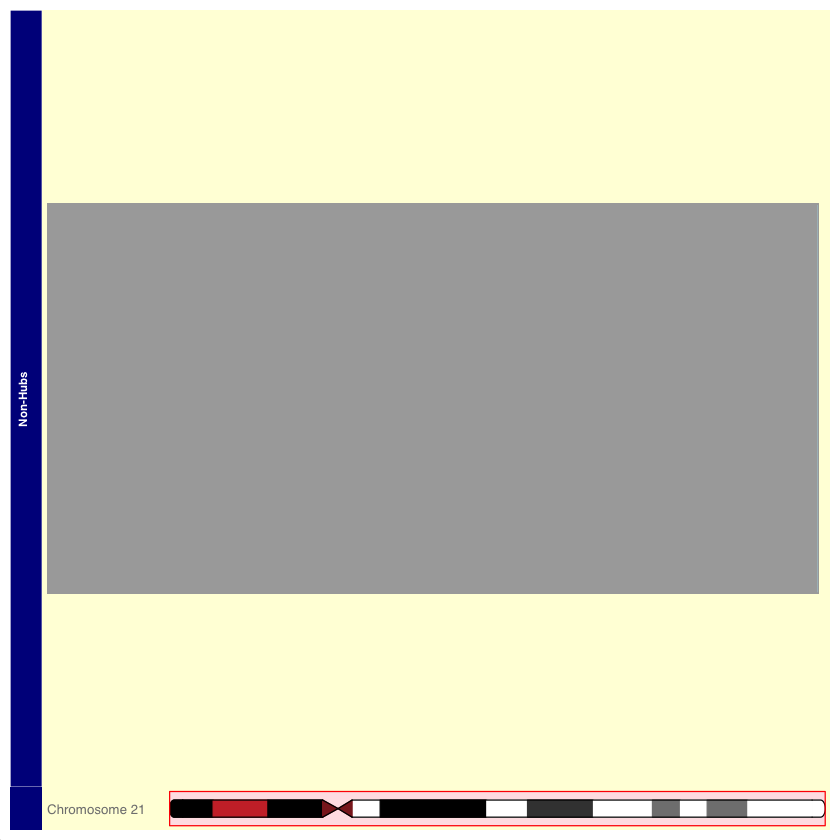

In [137]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = h1escgregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results.  

In [138]:
h1escgregPredicted <- cbind(h1escgregStandardRegionsClass, h1escgregModelPredictionsProbs)
names(h1escgregPredicted)[names(h1escgregPredicted)=="h1escgregModelPredictionsProbs"] <- "Prediction"
h1escgregPredicted$Prediction <- ifelse(h1escgregPredicted$Prediction == 1, "Non-Hub", "Hub")            

Let us see if the classifier predictions match with the original results.

In [139]:
h1escgregChr21PredicitedHub <- h1escgregPredicted[h1escgregPredicted$chr=="chr21" & h1escgregPredicted$Prediction=="Hub", ]
print(h1escgregChr21PredicitedHub)

         chr    start      end   Class Prediction
802189 chr21  9432001  9434000 Non-Hub        Hub
802192 chr21  9438001  9440000 Non-Hub        Hub
802385 chr21  9824001  9826000 Non-Hub        Hub
802386 chr21  9826001  9828000 Non-Hub        Hub
802387 chr21  9828001  9830000 Non-Hub        Hub
802388 chr21  9830001  9832000 Non-Hub        Hub
802389 chr21  9832001  9834000 Non-Hub        Hub
802390 chr21  9834001  9836000 Non-Hub        Hub
802396 chr21  9846001  9848000 Non-Hub        Hub
802397 chr21  9848001  9850000 Non-Hub        Hub
802399 chr21  9852001  9854000 Non-Hub        Hub
802400 chr21  9854001  9856000 Non-Hub        Hub
802401 chr21  9856001  9858000 Non-Hub        Hub
802413 chr21  9880001  9882000 Non-Hub        Hub
802414 chr21  9882001  9884000 Non-Hub        Hub
802428 chr21  9910001  9912000 Non-Hub        Hub
802434 chr21  9922001  9924000 Non-Hub        Hub
802436 chr21  9926001  9928000 Non-Hub        Hub
802822 chr21 10698001 10700000 Non-Hub        Hub


Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

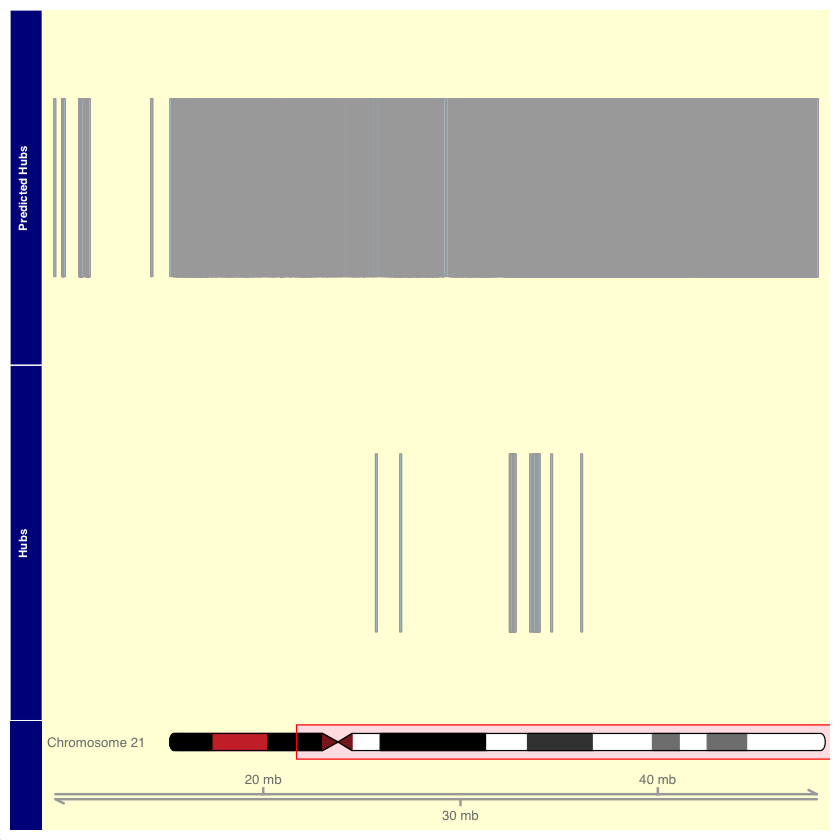

In [140]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = h1escgregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = h1escgregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

### <a id=link13>7. Session Information </a>

In [141]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.32.0          GenomicRanges_1.40.0 GenomeInfoDb_1.24.2 
 [4] IRanges_2.22.2       S4Vectors_0.26.1     BiocGenerics_0.34.0 
 [7] DMwR_0.4.1           ROCR_1.0-11          ROSE_0.0-3          
[10] e1071_1.7-3          caret_6.0-86         rms_6.0-1           
[13] SparseM_1.78         Hmisc_4.4-1          ggplot2_3.3.2       
[16] Formula_1.2-3        survival_3.2-3       lattice_0.20-41     
[19] glmnet_4.0-2         Matrix_1.2-18       

loaded via a namespace (and not attached):
  [1] uui